In [2]:
import sys
sys.path.append('/notebooks/models/research/slim/')

In [3]:
import argparse
import os
import numpy as np
try:
    import better_exceptions
except ImportError:
    pass
import tensorflow as tf
from src.model import crnn_fn
from src.data_handler import make_input_fn
from src.data_handler import preprocess_image_for_prediction

from src.config import Params, import_params_from_json

### Custom CNN

In [10]:
def deep_cnn(input_imgs: tf.Tensor, is_training=False, summaries=False):

    input_tensor = input_imgs
    if input_tensor.shape[-1] == 1:
        input_channels = 1
    elif input_tensor.shape[-1] == 3:
        input_channels = 3
    else:
        raise NotImplementedError

    # Following source code, not paper

    with tf.variable_scope('deep_cnn'):
        # - conv1 - maxPool2x2
        with tf.variable_scope('layer1'):
            W = weightVar([3, 3, input_channels, 64])
            b = biasVar([64])
            conv = conv2d(input_tensor, W, name='conv')
            out = tf.nn.bias_add(conv, b)
            conv1 = tf.nn.relu(out)
            pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], strides=[1, 2, 2, 1],
                                   padding='SAME', name='pool')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer1/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer1/bias:0'][0]
                tf.summary.histogram('bias', bias)


        # - conv2 - maxPool 2x2
        with tf.variable_scope('layer2'):
            W = weightVar([3, 3, 64, 128])
            b = biasVar([128])
            conv = conv2d(pool1, W)
            out = tf.nn.bias_add(conv, b)
            conv2 = tf.nn.relu(out)
            pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], strides=[1, 2, 2, 1],
                                   padding='SAME', name='pool1')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer2/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer2/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv3 - w/batch-norm (as source code, not paper)
        with tf.variable_scope('layer3'):
            W = weightVar([3, 3, 128, 256])
            b = biasVar([256])
            conv = conv2d(pool2, W)
            out = tf.nn.bias_add(conv, b)
            b_norm = tf.layers.batch_normalization(out, axis=-1,
                                                   training=is_training, name='batch-norm')
            conv3 = tf.nn.relu(b_norm, name='ReLU')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer3/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer3/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv4 - maxPool 2x1
        with tf.variable_scope('layer4'):
            W = weightVar([3, 3, 256, 256])
            b = biasVar([256])
            conv = conv2d(conv3, W)
            out = tf.nn.bias_add(conv, b)
            conv4 = tf.nn.relu(out)
            pool4 = tf.nn.max_pool(conv4, [1, 2, 2, 1], strides=[1, 2, 1, 1],
                                   padding='SAME', name='pool4')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer4/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer4/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv5 - w/batch-norm
        with tf.variable_scope('layer5'):
            W = weightVar([3, 3, 256, 512])
            b = biasVar([512])
            conv = conv2d(pool4, W)
            out = tf.nn.bias_add(conv, b)
            b_norm = tf.layers.batch_normalization(out, axis=-1,
                                                   training=is_training, name='batch-norm')
            conv5 = tf.nn.relu(b_norm)

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer5/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer5/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv6 - maxPool 2x1 (as source code, not paper)
        with tf.variable_scope('layer6'):
            W = weightVar([3, 3, 512, 512])
            b = biasVar([512])
            conv = conv2d(conv5, W)
            out = tf.nn.bias_add(conv, b)
            conv6 = tf.nn.relu(out)
            pool6 = tf.nn.max_pool(conv6, [1, 2, 2, 1], strides=[1, 2, 1, 1],
                                   padding='SAME', name='pool6')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer6/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer6/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv 7 - w/batch-norm (as source code, not paper)
        with tf.variable_scope('layer7'):
            W = weightVar([2, 2, 512, 512])
            b = biasVar([512])
            conv = conv2d(pool6, W, padding='VALID')
            out = tf.nn.bias_add(conv, b)
            b_norm = tf.layers.batch_normalization(out, axis=-1,
                                                   training=is_training, name='batch-norm')
            conv7 = tf.nn.relu(b_norm)

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer7/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer7/bias:0'][0]
                tf.summary.histogram('bias', bias)

        cnn_net = conv7

        with tf.variable_scope('Reshaping_cnn'):
            shape = cnn_net.get_shape().as_list()  # [batch, height, width, features]
            transposed = tf.transpose(cnn_net, perm=[0, 2, 1, 3],
                                      name='transposed')  # [batch, width, height, features]
            conv_reshaped = tf.reshape(transposed, [shape[0], -1, shape[1] * shape[3]],
                                       name='reshaped')  # [batch, width, height x features]

    return conv_reshaped

In [4]:
import cv2
import matplotlib.pyplot as plt

In [6]:
cp /notebooks/samples/0.png /tmp

In [5]:
from skimage import io, transform

def resize_img(img):
    return transform.rescale(img, 512 / img.shape[1], mode='constant', cval=255, clip=True, preserve_range=True)

(32, 256)
(1, 32, 256, 1)


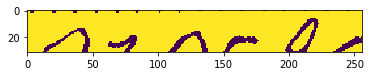

In [6]:
img = cv2.imread('/tmp/0.png', 0)[:32,:256]
plt.imshow(img)

print(img.shape)
# img = resize_img(img).reshape(1, -1, 512, 1)
img = img.reshape(1,32,-1,1).astype(np.float32)

print(img.shape)

In [7]:
def weightVar(shape, mean=0.0, stddev=0.02, name='weights'):
    init_w = tf.truncated_normal(shape=shape, mean=mean, stddev=stddev)
    return tf.Variable(init_w, name=name)


def biasVar(shape, value=0.0, name='bias'):
    init_b = tf.constant(value=value, shape=shape)
    return tf.Variable(init_b, name=name)


def conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME', name=None):
    return tf.nn.conv2d(input, filter, strides=strides, padding=padding, name=name)

In [11]:
with tf.Graph().as_default():
    conv = deep_cnn(img.astype(np.float32))

In [9]:
conv

NameError: name 'conv' is not defined

### Resnet-50

In [12]:
from nets.resnet_v1 import resnet_v1_50, resnet_v1_101

In [13]:
def reshape_cnn(cnn_input: tf.Tensor):
    with tf.variable_scope('Reshaping_cnn'):
        shape = cnn_input.get_shape().as_list()  # [batch, height, width, features]
        transposed = tf.transpose(cnn_input, perm=[0, 2, 1, 3],
                                  name='transposed')  # [batch, width, height, features]
        conv_reshaped = tf.reshape(transposed, [shape[0], -1, shape[1] * shape[3]],
                                   name='reshaped')  # [batch, width, height x features]
    return conv_reshaped

In [18]:
with tf.Graph().as_default():
    conv_res,_ = resnet_v1_50(img, global_pool=False, on_text=False)
    print(conv_res)
    conv_res = reshape_cnn(conv_res)
    print(conv_res)

Tensor("resnet_v1_50/block4/unit_3/bottleneck_v1/Relu:0", shape=(1, 1, 8, 2048), dtype=float32)
Tensor("Reshaping_cnn/reshaped:0", shape=(1, 8, 2048), dtype=float32)


### Resnet-101 

#### Standard

In [16]:
with tf.Graph().as_default():
    conv_res,_ = resnet_v1_101(img, global_pool=False, on_text=False)
    print(conv_res)
    conv_res = reshape_cnn(conv_res)
    print(conv_res)

Tensor("resnet_v1_101/block4/unit_3/bottleneck_v1/Relu:0", shape=(1, 1, 8, 2048), dtype=float32)
Tensor("Reshaping_cnn/reshaped:0", shape=(1, 8, 2048), dtype=float32)


#### on_text

In [17]:
with tf.Graph().as_default():
    conv_res_on_text,_ = resnet_v1_101(img, global_pool=False, on_text=True)
    print(conv_res_on_text)
    conv_res_on_text = reshape_cnn(conv_res_on_text)
    print(conv_res_on_text)

Tensor("resnet_v1_101/block4/unit_3/bottleneck_v1/Relu:0", shape=(1, 1, 63, 2048), dtype=float32)
Tensor("Reshaping_cnn/reshaped:0", shape=(1, 63, 2048), dtype=float32)


### Check graph ckpt pretrained resnet 

In [30]:
with tf.Graph().as_default():
    sess= tf.Session()
    saver = tf.train.import_meta_graph('/notebooks/resnet_pretrained/model.ckpt.meta')
    saver.restore(sess, '/notebooks/resnet_pretrained/model.ckpt.data-00000-of-00001')

INFO:tensorflow:Restoring parameters from /notebooks/resnet_pretrained/model.ckpt.data-00000-of-00001


DataLossError: Unable to open table file /notebooks/resnet_pretrained/model.ckpt.data-00000-of-00001: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[node save/RestoreV2 (defined at <ipython-input-30-d712e1b2f646>:3)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-d712e1b2f646>", line 3, in <module>
    saver = tf.train.import_meta_graph('/notebooks/resnet_pretrained/model.ckpt.meta')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1674, in import_meta_graph
    meta_graph_or_file, clear_devices, import_scope, **kwargs)[0]
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1696, in _import_meta_graph_with_return_elements
    **kwargs))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/meta_graph.py", line 806, in import_scoped_meta_graph_with_return_elements
    return_elements=return_elements)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/importer.py", line 442, in import_graph_def
    _ProcessNewOps(graph)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/importer.py", line 234, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3440, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3440, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3299, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

DataLossError (see above for traceback): Unable to open table file /notebooks/resnet_pretrained/model.ckpt.data-00000-of-00001: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[node save/RestoreV2 (defined at <ipython-input-30-d712e1b2f646>:3)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
